In [1]:
%matplotlib widget
from CG import *

In [3]:
%matplotlib inline
A = np.matrix([[3.0, 2.0], [2.0, 6.0]])
b = np.matrix([[2.0], [-8.0]])
c = 0.0

## 5. Thinking with Eigenvectors and Eigenvalues <a id="5"></a>

After my one course in linear algebra, I knew eigenvectors and eigenvalues like the back of my head. If your instructor was anything like mine, you recall solving problems involving eigendoohickeys, but you never really understood them. Unfortunately, without an intuitive grasp of them, CG won’t make sense either. If you’re already eigentalented, feel free to skip this section.
Eigenvectors are used primarily as an analysis tool; Steepest Descent and CG do not calculate the value of any eigenvectors as part of the algorithm.

However, there are practical applications for eigenvectors. The eigenvectors of the stiffness matrix associated with a discretized structure of uniform density represent the natural modes of vibration of the structure being studied. For instance, the eigenvectors of the stiffness matrix associated with a one-dimensional uniformly-spaced mesh are sine waves, and to express vibrations as a linear combination of these eigenvectors is equivalent to performing a discrete Fourier transform.

### 5.1 Eigen do it if I try <a id="5.1"></a>

An *eigenvector* $v$ of a matrix $B$ is a nonzero vector that does not rotate when $B$ is applied to it (except perhaps to point in precisely the opposite direction). $v$ may change length or reverse its direction, but it won’t turn sideways. In other words, there is some scalar constant $\lambda$ such that $Bv = \lambda v$. The value $\lambda$ is an *eigenvalue* of $B$. For any constant $\alpha$, the vector $\alpha v$ is also an eigenvector with eigenvalue $\lambda$, because $B(\alpha v) = \alpha Bv = \lambda\alpha v$. In other words, if you scale an eigenvector, it’s still an eigenvector.

Why should you care? Iterative methods often depend on applying $B$ to a vector over and over again. When $B$ is repeatedly applied to an eigenvector $v$, one of two things can happen. If $|\lambda|<1$, then $B^iv = \lambda^iv$ will vanish as $i$ approaches infinity (Figure 9). If $|\lambda|>1$, then will grow to infinity (Figure 10). Each time $B$ is applied, the vector grows or shrinks according to the value of $|\lambda|$.

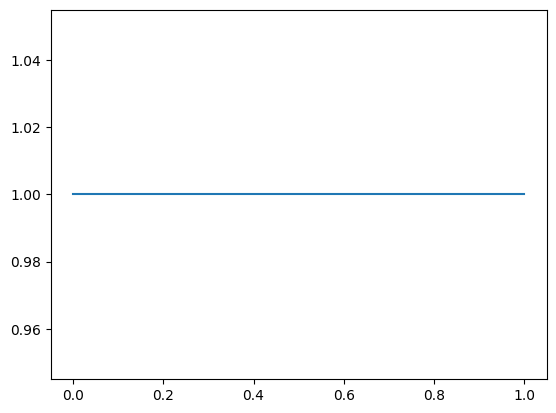

In [4]:
import matplotlib.pyplot as plt

x = [1, 1]
plt.plot(x)
plt.show()

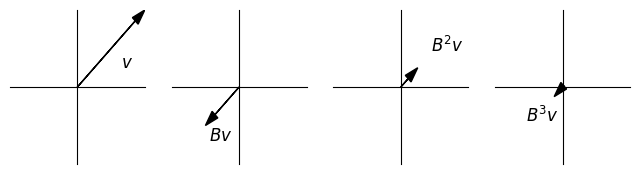

In [8]:
fig9()

<center>Figure 9: $v$ is an eigenvector of $B$ with a corresponding eigenvalue of -0.5. As $i$ increases, $B^iv$ converges to zero.</center>

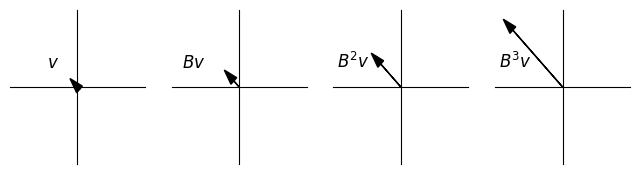

In [9]:
fig10()

If $B$ is symmetric (and often if it is not), then there exists a set of $n$ linearly independent eigenvectors of $B$, denoted $v_1, v_2, \dots, v_n$. This set is not unique, because each eigenvector can be scaled by an arbitrary nonzero constant. Each eigenvector has a corresponding eigenvalue, denoted $\lambda_1, \lambda_2, \dots, \lambda_n$. These are uniquely defined for a given matrix. The eigenvalues may or may not be equal to each other; for instance, the eigenvalues of the identity matrix $I$ are all one, and every nonzero vector is an eigenvector of $I$.

What if $B$ is applied to a vector that is not an eigenvector? A very important skill in understanding linear algebra — the skill this section is written to teach — is to think of a vector as a sum of other vectors whose behavior is understood. Consider that the set of eigenvectors ${v_i}$ forms a basis for $\mathbb{R}^n$ (because a symmetric $B$ has $n$ eigenvectors that are linearly independent). Any $n$-dimensional vector can be expressed as a linear combination of these eigenvectors, and because matrix-vector multiplication is distributive, one can examine the effect of $B$ on each eigenvector separately.

In Figure 11, a vector $x$ is illustrated as a sum of two eigenvectors $v_1$ and $v_2$. Applying $B$ to $x$ is equivalent to applying $B$ to the eigenvectors, and summing the result. On repeated application, we have $B^ix = B^iv_1 + B^iv_2 = \lambda^i_1 v_1 + \lambda^i_2 v_2$. If the magnitudes of all the eigenvalues are smaller than one, $B^ix$ will converge to zero, because the eigenvectors that compose converge to zero when $B$ is repeatedly applied. If one of the eigenvalues has magnitude greater than one, $x$ will diverge to infinity. This is why numerical analysts attach importance to the spectral radius of a matrix:

$$
\rho(B) = \text{max}|\lambda_i|,\quad \lambda_i \text{ is an eigenvalue of}\, B.
$$

If we want $x$ to converge to zero quickly, $\rho(B)$ should be less than one, and preferably as small as possible.

<center>Figure 10: Here $v$ has a corresponding eigenvalue of 2. As $i$ increases, $B^iv$ diverges to infinity.</center>

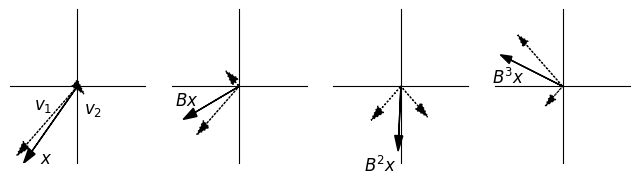

In [10]:
fig11()

<center>Figure 11: The vector $x$ (solid arrow) can be expressed as a linear combination of eigenvectors (dashed arrows), whose associated eigenvalues are $\lambda_1 = 0.7$ and $\lambda_2 = -2$. The effect of repeatedly applying $B$ to $x$ is best understood by examining the effect of $B$ on each eigenvector. When $B$ is repeatedly applied, one eigenvector converges to zero while the other diverges; hence, $B^ix$ also diverges.</center>

It’s important to mention that there is a family of nonsymmetric matrices that do not have a full set of $n$ independent eigenvectors. These matrices are known as *defective*, a name that betrays the well-deserved hostility they have earned from frustrated linear algebraists. The details are too complicated to describe in this article, but the behavior of defective matrices can be analyzed in terms of *generalized eigenvectors* and *generalized eigenvalues*. The rule that $B^ix$ converges to zero if and only if all the generalized eigenvalues have magnitude smaller than one still holds, but is harder to prove.

Here’s a useful fact: the eigenvalues of a positive-definite matrix are all positive. This fact can be proven from the definition of eigenvalue:

\begin{align*}
Bv &= \lambda v\\
v^TBv &= \lambda v^Tv.
\end{align*}

By the definition of positive-definite, the $v^TBv$ is positive (for nonzero $v$). Hence, $\lambda$ must be positive also.

### 5.2 Jacobi iterations <a id="5.2"></a>

Of course, a procedure that always converges to zero isn’t going to help you attract friends. Consider a more useful procedure: the Jacobi Method for solving $Ax=b$. The matrix is *split* into two parts: $D$, whose diagonal elements are identical to those of $A$, and whose off-diagonal elements are zero; and $E$, whose diagonal elements are zero, and whose off-diagonal elements are identical to those of $A$. Thus, $A=D+E$. We derive the Jacobi Method:

\begin{align}
Ax &= b \nonumber\\
Dx &= -Ex + b \nonumber\\
x&= -D^{-1}Ex + D^{-1}b \nonumber\\
x = Bx+z, \qquad \text{where}\, B &= -D^{-1}E, \qquad z =  D^{-1}b. \tag{14}
\end{align}

Because $D$ is diagonal, it is easy to invert. This identity can be converted into an iterative method by forming the recurrence

\begin{equation}
x_{[i+1]} = Bx_{[i]} + z. \tag{15}
\end{equation}

Given a starting vector $x_{[0]}$, this formula generates a sequence of vectors. Our hope is that each successive vector will be closer to the solution $x$ than the last. $x$ is called a *stationary point* of Equation 15, because if $x_{[i]} = x$, then $x_{[i+1]}$ will also equal $x$.

Now, this derivation may seem quite arbitrary to you, and you’re right. We could have formed any number of identities for instead of Equation 14. In fact, simply by splitting $A$ differently — that is, by choosing a different $D$ and $E$ — we could have derived the Gauss-Seidel method, or the method of Successive Over-Relaxation (SOR). Our hope is that we have chosen a splitting for which $B$ has a small spectral radius. Here, I chose the Jacobi splitting arbitrarily for simplicity.

Suppose we start with some arbitrary vector $x_{[0]}$. For each iteration, we apply $B$ to this vector, then add $z$ to the result. What does each iteration do?

Again, apply the principle of thinking of a vector as a sum of other, well-understood vectors. Express each iterate $x_{[i]}$ as the sum of the exact solution $x$ and the error term $e_{[i]}$. Then, Equation 15 becomes

\begin{align*}
x_{[i+1]} &= Bx_{[i]} + z \\
&= B(x + e_{[i]}) + z \\
&= Bx + z + Be_{[i]} \\
&= x + Be_{[i]} \qquad \text{(by Equation 14),} \\
\therefore\, e_{[i+1]} &= Be_{[i]}. \tag{16}
\end{align*}

Each iteration does not affect the “correct part” of $x_{[i]}$ (because $x$ is a stationary point); but each iteration does affect the error term. It is apparent from Equation 16 that if $\rho(B) < 1$, then the error term $e_{[i]}$ will converge to zero as $i$ approaches infinity. Hence, the initial vector $x_{[0]}$ has no effect on the inevitable outcome!

Of course, the choice of $x_{[0]}$ does affect the number of iterations required to converge to $x$ within a given tolerance. However, its effect is less important than that of the spectral radius $\rho(B)$, which determines the speed of convergence. Suppose that $v_j$ is the eigenvector of $B$ with the largest eigenvalue (so that $\rho(B) \lambda_j$). If the initial error $e_{[0]}$, expressed as a linear combination of eigenvectors, includes a component in the direction of $v_j$, this component will be the slowest to converge.

$B$ is not generally symmetric (even if $A$ is), and may even be defective. However, the rate of convergence of the Jacobi Method depends largely on $\rho(B)$, which depends on $A$. Unfortunately, Jacobi does not converge for every $A$, or even for every positive-definite $A$.

### 5.3. A Concrete Example <a id="5.3"></a>

To demonstrate these ideas, I shall solve the system specified by Equation 4. First, we need a method of finding eigenvalues and eigenvectors. By definition, for any eigenvector $v$ with eigenvalue $\lambda$,

$$
Av = \lambda v = \lambda Iv\\
(\lambda I- A)v =0.
$$

Eigenvectors are nonzero, so $\lambda v - I$ must be singular. Then, 

$$
\text{det}(\lambda I - A) = 0.
$$

The determinant of $\lambda I - A$ is called the *characteristic polynomial*. It is a degree $n$ polynomial in $\lambda$ whose roots are the set of eigenvalues. The characteristic polynomial of $A$ (from Equation 4) is

$$
\text{det} \begin{bmatrix} \lambda - 3 & -2 \\ -2 & \lambda - 6 \end{bmatrix} = \lambda^2-9\lambda+14=(\lambda-7)(\lambda-2)
$$

and the eigenvalues are 7 and 2. To find the eigenvector associated with $\lambda = 7$,

$$
(\lambda I -A)v = \begin{bmatrix} 4 & -2 \\ -2 & 1 \end{bmatrix} \begin{bmatrix} v_1 \\ v_2 \end{bmatrix} = 0\\
\therefore\, 4v_1 - 2v_2 = 0.
$$

Any solution to this equation is an eigenvector; say, $v = [1, 2]^T$. By the same method, we find that $[-2, 1]^T$ is an eigenvector corresponding to the eigenvalue 2. In Figure 12, we see that these eigenvectors coincide with the axes of the familiar ellipsoid, and that a larger eigenvalue corresponds to a steeper slope. (Negative eigenvalues indicate that $f$ decreases along the axis, as in Figures 5(b) and 5(d).)

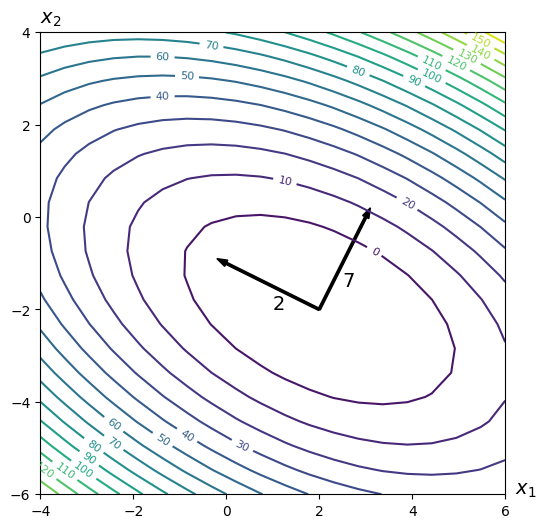

In [3]:
fig12(A, b, c)

<center>Figure 12: The eigenvectors of $A$ are directed along the axes of the paraboloid defined by the quadratic form $f(x)$. Each eigenvector is labeled with its associated eigenvalue. Each eigenvalue is proportional to the steepness of the corresponding slope.</center>

Now, let’s see the Jacobi Method in action. Using the constants specified by Equation 4, we have

\begin{align*}
x_{[i+1]} &= -\begin{bmatrix} \mbox{1/3} & 0 \\ 0 & \mbox{1/6}\end{bmatrix} \begin{bmatrix} 0 & 2\\2 & 0\end{bmatrix} x_{[i]} + \begin{bmatrix} \mbox{1/3} & 0 \\ 0 & \mbox{1/6}\end{bmatrix} \begin{bmatrix} 2 \\ -8\end{bmatrix} \\
&= \begin{bmatrix} 0 & -\mbox{2/3} \\ -\mbox{1/3} & 0 \end{bmatrix} x_{[i]} + \begin{bmatrix} \mbox{2/3} \\ -\mbox{4/3} \end{bmatrix}
\end{align*}

The eigenvectors of $B$ are $[\sqrt{2}, 1]^T$ with eigenvalue $-\sqrt{2}/3$, and $[-\sqrt{2}, 1]^T$ with eigenvalue $\sqrt{2}/3$. These are graphed in Figure 13(a); note that they do not coincide with the eigenvectors of $A$, and are not related to the axes of the paraboloid.

Figure 13(b) shows the convergence of the Jacobi method. The mysterious path the algorithm takes can be understood by watching the eigenvector components of each successive error term (Figures 13(c), (d), and (e)). Figure 13(f) plots the eigenvector components as arrowheads. These are converging normally at the rate defined by their eigenvalues, as in Figure 11.

I hope that this section has convinced you that eigenvectors are useful tools, and not just bizarre torture devices inflicted on you by your professors for the pleasure of watching you suffer (although the latter is a nice fringe benefit).

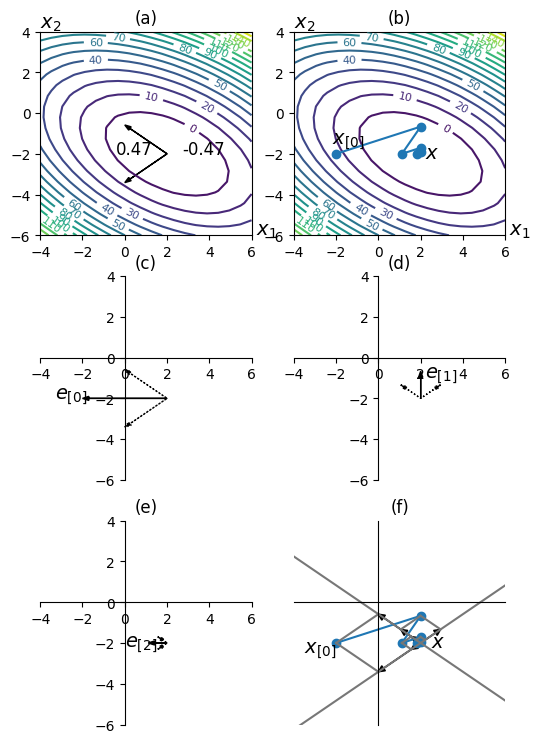

In [4]:
fig13()

<center>Figure 13: Convergence of the Jacobi Method. (a) The eigenvectors of $B$ are shown with their corresponding eigenvalues. Unlike the eigenvectors of $A$, these eigenvectors are not the axes of the paraboloid. (b) The Jacobi Method starts at $[-2, -2]^T$ and converges at $[2, -2]^T$. (c, d, e) The error vectors $e_{[0]}, e_{[1]}, e_{[2]}$ (solid arrows) and their eigenvector components (dashed arrows). (f) Arrowheads represent the eigenvector components of the first four error vectors. Each eigenvector component of the error is converging to zero at the expected rate based on its eigenvalue.</center>

Next: [6. Convergence Analysis of Steepest Descent](CG06.ipynb)